# 05a: Level Set Analysis

**Goal**: Compute level set connectivity for each V value.

A level set L_v = {states s : V(s) = v}. We examine:
1. How many connected components does each level set have?
2. How are states distributed across V values?
3. Is V a "nice" function (few components) or fragmented (many components)?

**Reference**: docs/analysis-draft.md Section 5.1

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load Data for Single Seed

In [2]:
# Load first available shard
shard_files = loading.find_shard_files(DATA_DIR)
df, seed, decl_id = schema.load_file(shard_files[0])

print(f"Seed: {seed}")
print(f"Declaration: {decl_id} ({schema.DECL_NAMES[decl_id]})")
print(f"Total states: {len(df):,}")

Seed: 0
Declaration: 0 (blanks)
Total states: 7,607,411


In [3]:
# Build state lookup
state_to_idx, V_arr, Q_arr = navigation.build_state_lookup_fast(df)
states = df['state'].values
V = df['V'].values

print(f"Built lookup for {len(state_to_idx):,} states")
print(f"V range: [{V.min()}, {V.max()}]")

Built lookup for 7,607,411 states
V range: [-34, 42]


## 2. Level Set Size Distribution

In [4]:
# Count states at each V value
v_counts = pd.Series(V).value_counts().sort_index()
print(f"Unique V values: {len(v_counts)}")
print(f"\nLevel set sizes:")
print(v_counts.describe())

Unique V values: 76

Level set sizes:
count        76.000000
mean     100097.513158
std      176647.802259
min          36.000000
25%        4048.000000
50%       20407.500000
75%      117448.000000
max      855575.000000
Name: count, dtype: float64


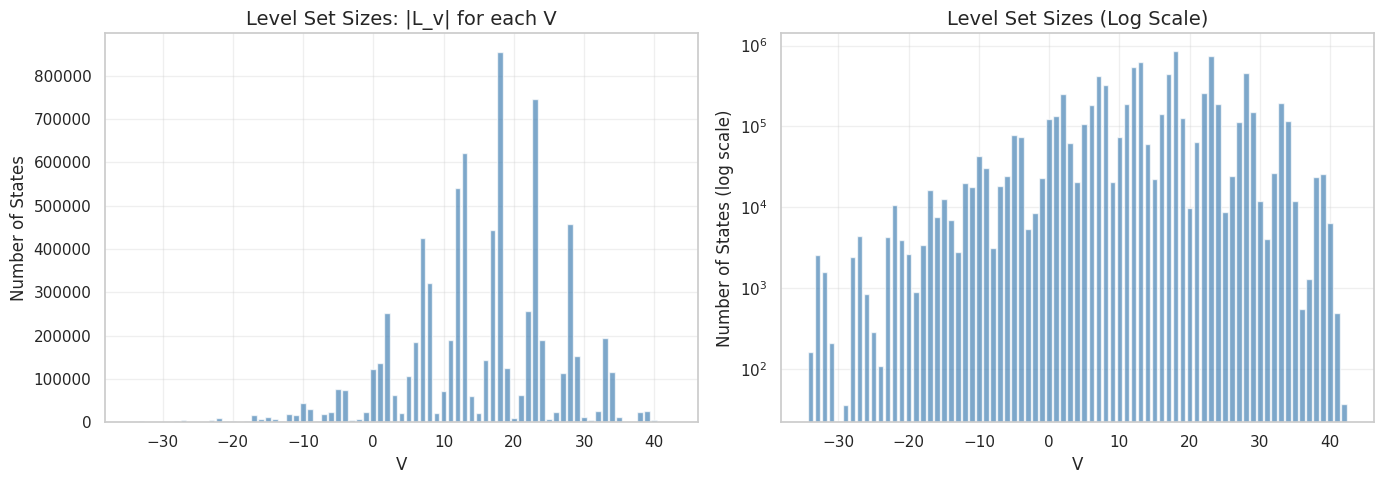

In [5]:
# Visualize level set sizes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of level set sizes
axes[0].bar(v_counts.index, v_counts.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('V')
axes[0].set_ylabel('Number of States')
axes[0].set_title('Level Set Sizes: |L_v| for each V')

# Log scale version
axes[1].bar(v_counts.index, v_counts.values, color='steelblue', alpha=0.7)
axes[1].set_xlabel('V')
axes[1].set_ylabel('Number of States (log scale)')
axes[1].set_title('Level Set Sizes (Log Scale)')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('../../results/figures/05a_level_set_sizes.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Level Set Connectivity

For each V value, build the adjacency graph within that level set and count connected components.

In [6]:
def get_successors(state: int, q_values: np.ndarray, seed: int, decl_id: int) -> list[int]:
    """Get all successor states from current state."""
    successors = []
    for local_idx in range(7):
        if q_values[local_idx] != -128:  # Legal move
            succ = navigation.compute_successor(state, local_idx, seed, decl_id)
            successors.append(succ)
    return successors


def count_components_union_find(states_in_level: set, adj_pairs: list[tuple[int, int]]) -> int:
    """Count connected components using union-find."""
    if len(states_in_level) == 0:
        return 0
    
    parent = {s: s for s in states_in_level}
    
    def find(x):
        if parent[x] != x:
            parent[x] = find(parent[x])
        return parent[x]
    
    def union(x, y):
        px, py = find(x), find(y)
        if px != py:
            parent[px] = py
    
    for a, b in adj_pairs:
        union(a, b)
    
    roots = set(find(s) for s in states_in_level)
    return len(roots)

In [7]:
# Build adjacency list for all states
# Only store edges where both endpoints are in our state set
print("Building adjacency structure...")

state_set = set(states)
adjacency = defaultdict(list)

for i, state in enumerate(tqdm(states, desc="Computing successors")):
    q = Q_arr[i]
    for succ in get_successors(int(state), q, seed, decl_id):
        if succ in state_set:
            adjacency[int(state)].append(succ)

print(f"Built adjacency for {len(adjacency):,} states")

Building adjacency structure...


Computing successors:   0%|          | 0/7607411 [00:00<?, ?it/s]

Built adjacency for 7,607,407 states


In [8]:
# Compute connected components for each level set
level_set_analysis = []

for v in tqdm(sorted(v_counts.index), desc="Analyzing level sets"):
    # Get states at this V value
    mask = V == v
    level_states = set(int(s) for s in states[mask])
    
    if len(level_states) == 0:
        continue
    
    # Find edges within level set
    # Note: For level sets, adjacency means "one move apart in game tree"
    # But states at same V are typically NOT one move apart (V changes with moves)
    # So we look at adjacency through the full graph and check if both endpoints have same V
    
    # Actually, for level set connectivity we need a different notion:
    # Two states at same V are "connected" if there's a path through states at same V
    # This is rare - V typically changes with each move
    
    # Let's instead count "reachability components" - states that can reach each other
    # through ANY path (not just staying in level set)
    adj_pairs = []
    for s in level_states:
        for t in adjacency.get(s, []):
            if t in level_states:
                adj_pairs.append((s, t))
    
    n_components = count_components_union_find(level_states, adj_pairs)
    
    level_set_analysis.append({
        'v': v,
        'n_states': len(level_states),
        'n_components': n_components,
        'n_edges': len(adj_pairs),
        'fragmentation': n_components / len(level_states) if len(level_states) > 0 else 0,
    })

level_df = pd.DataFrame(level_set_analysis)
print(f"Analyzed {len(level_df)} level sets")

Analyzing level sets:   0%|          | 0/76 [00:00<?, ?it/s]

Analyzed 76 level sets


In [9]:
print("Level set statistics:")
print(level_df.describe())

Level set statistics:
               v       n_states  n_components        n_edges  fragmentation
count  76.000000      76.000000     76.000000      76.000000      76.000000
mean    4.447368  100097.513158  16276.828947   83820.684211       0.314910
std    22.171089  176647.802259  21938.832365  161351.816462       0.217965
min   -34.000000      36.000000      1.000000      10.000000       0.027027
25%   -14.250000    4048.000000   1194.000000    2065.500000       0.116595
50%     4.500000   20407.500000   5491.000000   12627.500000       0.294897
75%    23.250000  117448.000000  25685.250000   83261.750000       0.474439
max    42.000000  855575.000000  81984.000000  792261.000000       0.908989


## 4. Visualization

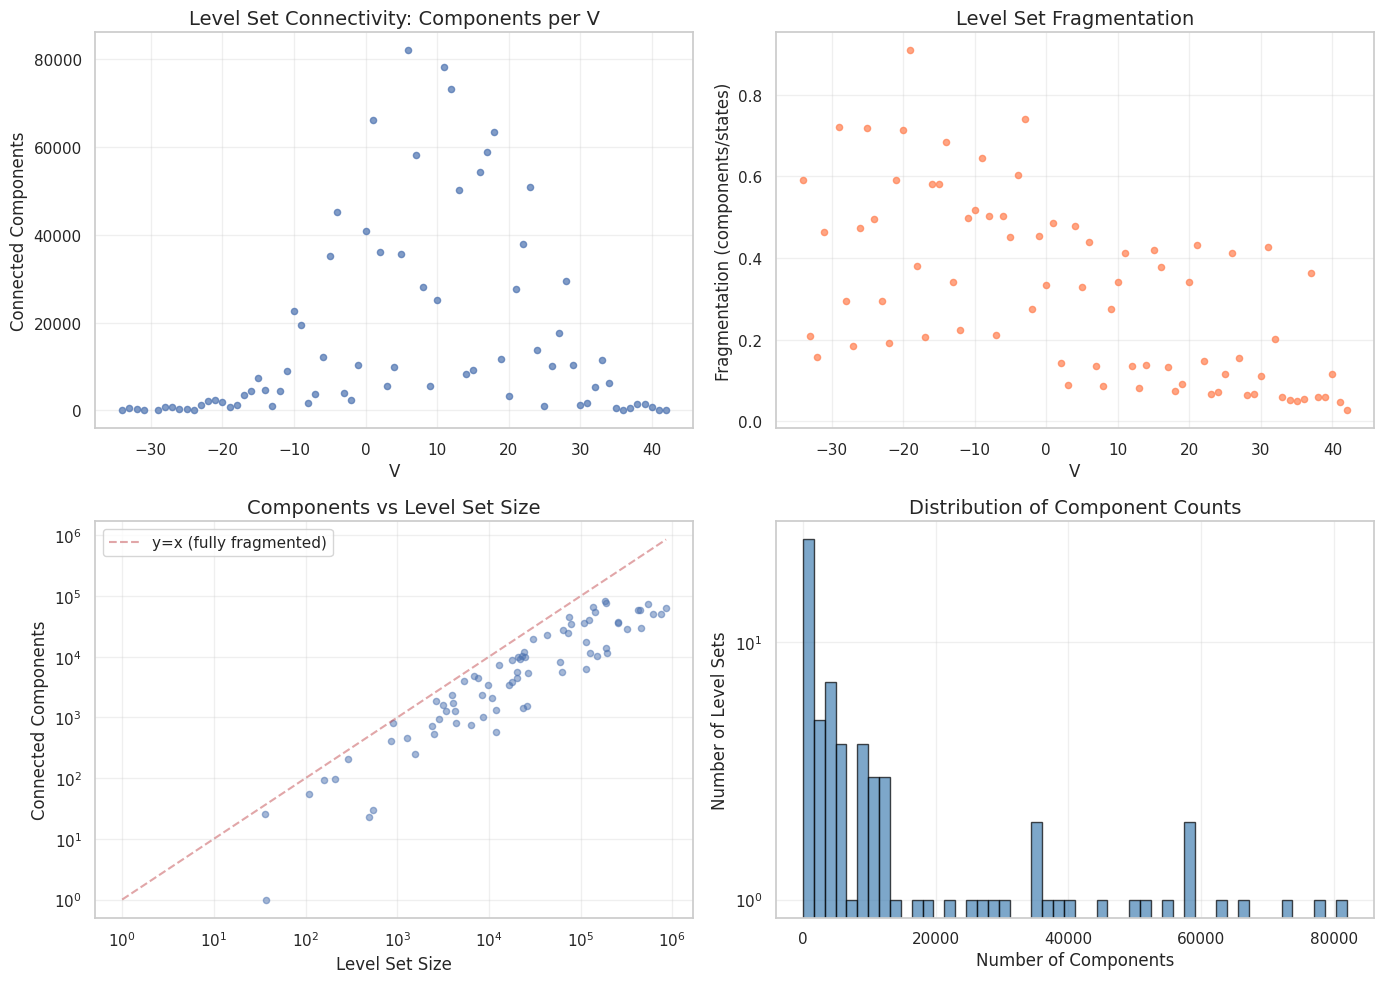

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Number of components per level set
axes[0, 0].scatter(level_df['v'], level_df['n_components'], alpha=0.7, s=20)
axes[0, 0].set_xlabel('V')
axes[0, 0].set_ylabel('Connected Components')
axes[0, 0].set_title('Level Set Connectivity: Components per V')

# Fragmentation ratio
axes[0, 1].scatter(level_df['v'], level_df['fragmentation'], alpha=0.7, s=20, color='coral')
axes[0, 1].set_xlabel('V')
axes[0, 1].set_ylabel('Fragmentation (components/states)')
axes[0, 1].set_title('Level Set Fragmentation')

# Components vs level set size
axes[1, 0].scatter(level_df['n_states'], level_df['n_components'], alpha=0.5, s=20)
axes[1, 0].set_xlabel('Level Set Size')
axes[1, 0].set_ylabel('Connected Components')
axes[1, 0].set_title('Components vs Level Set Size')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
# Add y=x reference line
max_val = max(level_df['n_states'].max(), level_df['n_components'].max())
axes[1, 0].plot([1, max_val], [1, max_val], 'r--', alpha=0.5, label='y=x (fully fragmented)')
axes[1, 0].legend()

# Distribution of component counts
axes[1, 1].hist(level_df['n_components'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Number of Components')
axes[1, 1].set_ylabel('Number of Level Sets')
axes[1, 1].set_title('Distribution of Component Counts')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.savefig('../../results/figures/05a_level_set_connectivity.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Edge Analysis

How often do transitions stay within the same V level?

In [11]:
# Count transitions that preserve V vs change V
same_v_transitions = 0
diff_v_transitions = 0
v_changes = []

for i, state in enumerate(states[:50000]):  # Sample for efficiency
    q = Q_arr[i]
    v_current = V[i]
    
    for succ in get_successors(int(state), q, seed, decl_id):
        if succ in state_to_idx:
            succ_idx = state_to_idx[succ]
            v_succ = V_arr[succ_idx]
            
            if v_succ == v_current:
                same_v_transitions += 1
            else:
                diff_v_transitions += 1
                v_changes.append(v_succ - v_current)

print(f"Same-V transitions: {same_v_transitions:,} ({100*same_v_transitions/(same_v_transitions+diff_v_transitions):.1f}%)")
print(f"Different-V transitions: {diff_v_transitions:,} ({100*diff_v_transitions/(same_v_transitions+diff_v_transitions):.1f}%)")

Same-V transitions: 0 (0.0%)
Different-V transitions: 99,772 (100.0%)


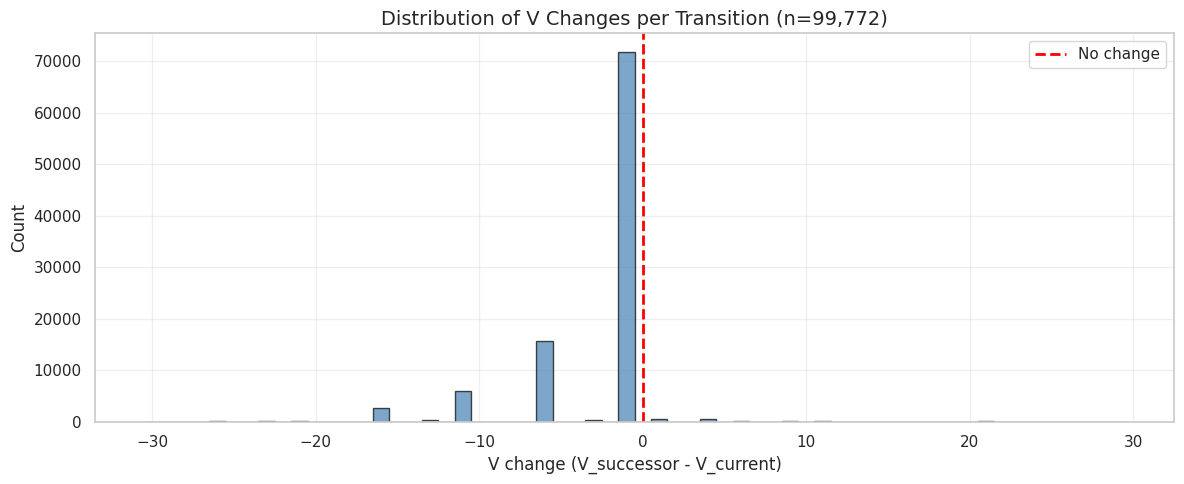


V change statistics:
  Mean: -2.85
  Std: 4.34
  Median: -1.0


In [12]:
# Distribution of V changes
fig, ax = plt.subplots(figsize=(12, 5))

v_changes_arr = np.array(v_changes)
ax.hist(v_changes_arr, bins=np.arange(-30, 31) - 0.5, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No change')
ax.set_xlabel('V change (V_successor - V_current)')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of V Changes per Transition (n={len(v_changes):,})')
ax.legend()

plt.tight_layout()
plt.savefig('../../results/figures/05a_v_transitions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nV change statistics:")
print(f"  Mean: {np.mean(v_changes_arr):.2f}")
print(f"  Std: {np.std(v_changes_arr):.2f}")
print(f"  Median: {np.median(v_changes_arr):.1f}")

## Summary

In [13]:
# Compute summary metrics
avg_fragmentation = level_df['fragmentation'].mean()
max_components = level_df['n_components'].max()
median_components = level_df['n_components'].median()

summary = {
    'Total states': f"{len(states):,}",
    'Unique V values': len(v_counts),
    'Mean level set size': f"{v_counts.mean():.1f}",
    'Median components per level': f"{median_components:.0f}",
    'Max components in a level': f"{max_components:,}",
    'Avg fragmentation': f"{avg_fragmentation:.4f}",
    'Same-V transitions': f"{100*same_v_transitions/(same_v_transitions+diff_v_transitions):.1f}%",
}

print(viz.create_summary_table(summary, "Level Set Analysis Summary"))

### Level Set Analysis Summary

| Metric | Value |
|--------|-------|
| Total states | 7,607,411 |
| Unique V values | 76 |
| Mean level set size | 100097.5 |
| Median components per level | 5491 |
| Max components in a level | 81,984 |
| Avg fragmentation | 0.3149 |
| Same-V transitions | 0.0% |


In [14]:
# Save results
level_df.to_csv('../../results/tables/05a_level_set_analysis.csv', index=False)
print("Results saved to results/tables/05a_level_set_analysis.csv")

Results saved to results/tables/05a_level_set_analysis.csv
